Нейросеть для распознавания болезней по симптомам.


Самостоятельно напишите нейронную сеть, которая поможет распознавать болезни по симптомам. Используя подготовленную базу, создайте и обучите нейронную сеть, распознающую десять категорий 
заболеваний: аппендицит, гастрит, гепатит, дуоденит, колит, панкреатит, холицестит, эзофагит, энтерит, язва. Добейтесь правильного распознавания 7 и более заболеваний

Сразу обратим внимание датасет небольшой и хороших результатов добится  сложно.

Ссылка на датасет:https://storage.googleapis.com/datasets_ai/Data/diseases.zip

In [ ]:
# Работа с массивами данных
import numpy as np 

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Рисование схемы модели
from tensorflow.keras.utils import plot_model

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Отрисовка графиков
import matplotlib.pyplot as plt

# Вывод объектов в ячейке colab
from IPython.display import display

%matplotlib inline

In [ ]:
# Скачаем архив с симптомами болезней
import gdown
gdown.download('https://storage.googleapis.com/datasets_ai/Data/diseases.zip', None, quiet=True)

'diseases.zip'

In [ ]:
# Распакум архив
!unzip -o diseases.zip

Archive:  diseases.zip
  inflating: dis/Аппендицит.txt  
  inflating: dis/Гастрит.txt  
  inflating: dis/Гепатит.txt  
  inflating: dis/Дуоденит.txt  
  inflating: dis/Колит.txt      
  inflating: dis/Панкреатит.txt  
  inflating: dis/Холицестит.txt  
  inflating: dis/Эзофагит.txt  
  inflating: dis/Энтерит.txt  
  inflating: dis/Язва.txt        


In [ ]:
FILE_DIR  = 'dis/'                     # Папка с текстовыми файлами

In [ ]:
# Подготовим пустые списки

CLASS_LIST = []  # Список классов 
text_train = []  # Список для оучающей выборки
text_test = []   # Список для тестовой выборки


# Зададим коэффициент разделения текста на обучающую и текстовую выборки
split_coef = 0.8

# Получим списки файлов в папке
file_list = os.listdir(FILE_DIR)

for file_name in file_list:
    m = file_name.split('.') # Разделим имя файла и расширение
    class_name = m[0]        # Из имени файла получим название класса
    ext = m[1]               # Выделим расширение файла                       

    if ext=='txt':                                         # Если расширение txt то берем файл в работу    
        if class_name not in CLASS_LIST:                   # Проверим, есть уже такой класс в списке
            print(f'Добавление класса "{class_name}"')     # Выведем имя нового класса
            CLASS_LIST.append(class_name)                  # Добавим новый класс в списоккласса "{class_name}"')

        cls = CLASS_LIST.index(class_name)                                        # Получим индекс (номер) нового класса
        print(f'Добавление файла "{file_name}" в класс "{CLASS_LIST[cls]}"')      # Сообщим о появлении нового класса

        with open(f'{FILE_DIR}/{file_name}', 'r') as f: # Откроем файл на чтение
            text = f.read()                                                       # Загрузка содержимого файла в строку
            text = text.replace('\n', ' ').split(' ')                             # Уберем символы перевода строк, получим список слов
            text_len=len(text)                                                    # Найдем количество прочитанных слов
            text_train.append(' '.join(text[:int(text_len*split_coef)]))          # Выделим часть файла в обучающую выборку
            text_test.append(' '.join(text[int(text_len*split_coef):]))           # Выделим часть файла в тестовую выборку



Добавление класса "Холицестит"
Добавление файла "Холицестит.txt" в класс "Холицестит"
Добавление класса "Аппендицит"
Добавление файла "Аппендицит.txt" в класс "Аппендицит"
Добавление класса "Колит"
Добавление файла "Колит.txt" в класс "Колит"
Добавление класса "Гастрит"
Добавление файла "Гастрит.txt" в класс "Гастрит"
Добавление класса "Язва"
Добавление файла "Язва.txt" в класс "Язва"
Добавление класса "Эзофагит"
Добавление файла "Эзофагит.txt" в класс "Эзофагит"
Добавление класса "Панкреатит"
Добавление файла "Панкреатит.txt" в класс "Панкреатит"
Добавление класса "Гепатит"
Добавление файла "Гепатит.txt" в класс "Гепатит"
Добавление класса "Дуоденит"
Добавление файла "Дуоденит.txt" в класс "Дуоденит"
Добавление класса "Энтерит"
Добавление файла "Энтерит.txt" в класс "Энтерит"


In [ ]:
# Найдем получившееся количество классов
CLASS_COUNT = len(CLASS_LIST) 

In [ ]:
# Выведем число получившихся классов
print(CLASS_COUNT)

10


In [ ]:
# Проверим загрузки: выведем начальные отрывки из каждого класса

for cls in range(CLASS_COUNT):             # Запустим цикл по числу классов
    print(f'Класс: {CLASS_LIST[cls]}')     # Выведем имя класса
    print(f'  train: {text_train[cls]}')   # Выведем фрагмент обучающей выборки
    print(f'  test : {text_test[cls]}')    # Выведем фрагмент тестовой выборки
    print()

Класс: Холицестит
  train: тупая, ноющая боль в области правого подреберья постоянного характера или возникающая через 1–3 ч после приема обильной и особенно жирной и жареной пищи. Боль иррадиирует вверх, в область правого плеча и шеи, правой лопатки.  Периодически  резкая боль, напоминающая желчную колику. диспепсические явления:  ощущение горечи и металлического вкуса во рту,  отрыжка воздухом, тошнота, метеоризм, нарушение дефекации(чередование запора и поноса),  раздражительность,  бессонница.  Нарушение пищеварения Присутствие болевых ощущений справа (может проецироваться в область правой руки или лопатки) Постоянная тошнота, отрыжка Озноб Пожелтение кожных покровов Нарушение аппетита Чрезмерное газообразование  Тяжесть и боль в правом боку, под ребрами, в лопатке Регулярная отрыжка и горечь во рту Постоянные проблемы с пищеварением (отсутствие аппетита, тошнота и рвота и др.) Проявление желтушных признаков  Внезапная слабость и горечь во рту Человеку не удобно любое положение, пр

In [ ]:
# Контекстный менеджер для измерения времени операций
# Операция обертывается менеджером с помощью оператора with

class timex:
    def __enter__(self):
        # Фиксация времени старта процесса
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        # Вывод времени работы
        print('Время обработки: {:.2f} с'.format(time.time() - self.t))

In [ ]:
#ваше решение



In [ ]:
# ваше решение
# Задание параметров преобразования
VOCAB_SIZE = 20000                        # Объем словаря для токенизатора
WIN_SIZE   = 50                         # Длина отрезка текста (окна) в словах
WIN_HOP    = 5                          # Шаг окна разбиения текста на векторы

In [ ]:
# Токенизация и построение частотного словаря по обучающим текстам
with timex():
    # Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
    tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)

    # Использованы параметры:
    # num_words   - объем словаря
    # filters     - убираемые из текста ненужные символы
    # lower       - приведение слов к нижнему регистру
    # split       - разделитель слов
    # char_level  - указание разделять по словам, а не по единичным символам
    # oov_token   - токен для слов, которые не вошли в словарь

    # Построение частотного словаря по обучающим текстам
    tokenizer.fit_on_texts(text_train)
    
    # Построение словаря в виде пар слово - индекс
    items = list(tokenizer.word_index.items())

Время обработки: 0.01 с


In [ ]:
# Преобразование обучающих и проверочных текстов текст в последовательности индексов согласно частотному словарю
with timex():
    seq_train = tokenizer.texts_to_sequences(text_train)
    seq_test = tokenizer.texts_to_sequences(text_test)

    print("Фрагмент обучающего текста:")
    print("В виде оригинального текста:              ", text_train[1][:101])
    print("Он же в виде последовательности индексов: ", seq_train[1][:20])

Фрагмент обучающего текста:
В виде оригинального текста:               Резкая боль в животе Повышение температуры Напряженность мышц Тошнота  Острая боль в животе, в том чи
Он же в виде последовательности индексов:  [98, 4, 2, 10, 24, 23, 822, 186, 6, 78, 4, 2, 10, 2, 823, 824, 3, 11, 825, 24]
Время обработки: 0.01 с


In [ ]:
# Функция вывода статистики по текстам
def print_text_stats(title, texts, sequences, class_labels=CLASS_LIST):
    # Суммарное количество символов и слов в тексте
    chars = 0
    words = 0

    print(f'Статистика по {title} текстам:')

    # Вывод итогов по всем классам данного набора текстов и их последовательностей индексов
    for cls in range(len(class_labels)):
        print('{:<15} {:9} символов,{:8} слов'.format(class_labels[cls],
                                                      len(texts[cls]),
                                                      len(sequences[cls])))
        chars += len(texts[cls])
        words += len(sequences[cls])

    print('----')
    print('{:<15} {:9} символов,{:8} слов\n'.format('В сумме', chars, words))

# Вывод итогов по текстам
print_text_stats('обучающим', text_train, seq_train)
print_text_stats('тестовым', text_test, seq_test)

Статистика по обучающим текстам:
Холицестит           4951 символов,     675 слов
Аппендицит           3257 символов,     471 слов
Колит                7262 символов,     950 слов
Гастрит              5440 символов,     660 слов
Язва                 2728 символов,     376 слов
Эзофагит             4647 символов,     639 слов
Панкреатит           9217 символов,    1183 слов
Гепатит              4385 символов,     555 слов
Дуоденит             3186 символов,     393 слов
Энтерит              5151 символов,     662 слов
----
В сумме             50224 символов,    6564 слов

Статистика по тестовым текстам:
Холицестит           1205 символов,     166 слов
Аппендицит            817 символов,     108 слов
Колит                1864 символов,     242 слов
Гастрит              1276 символов,     179 слов
Язва                  731 символов,      96 слов
Эзофагит             1219 символов,     154 слов
Панкреатит           2095 символов,     297 слов
Гепатит              1137 символов,     132 сло

Минимальная и максимальная длинна описания

In [ ]:
SequencyLenMin=100000000000
SequencyLenMax=0
for cls in range(len(seq_train)):
  if(len(seq_train[cls])>SequencyLenMax):SequencyLenMax=len(seq_train[cls])
  if(len(seq_train[cls])<SequencyLenMin):SequencyLenMin=len(seq_train[cls])
print(SequencyLenMin,SequencyLenMax)

376 1183


Балансировка классов копированием

In [ ]:
seq_train_balanced=[]
#temp_seq=np.zeros((SequencyLenMax),dtype=int)
for seq in seq_train:
  ptr=0
  CurrentLen=len(seq)
  temp_seq=np.array(seq)
  while(len(temp_seq)<SequencyLenMax):
    AddEntries=SequencyLenMax-len(temp_seq)
    if(AddEntries>len(temp_seq)):
          AddEntries=np.size(temp_seq)
    temp_seq=np.hstack((temp_seq,temp_seq[0:AddEntries]))
  seq_train_balanced.append(temp_seq)

In [ ]:
def split_sequence(sequence,   # Последовательность индексов
                   win_size,   # Размер окна для деления на примеры
                   hop):       # Шаг окна

    # Последовательность разбивается на части до последнего полного окна
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

In [ ]:
def vectorize_sequence(seq_list,    # Список последовательностей индексов 
                       win_size,    # Размер окна для деления на примеры
                       hop):        # Шаг окна

    # В списке последовательности следуют в порядке их классов (их кол-во сповпадает с кол-вом классов)
    class_count = len(seq_list)

    # Списки для исходных векторов и категориальных меток класса
    x, y = [], []

    # Для каждого класса:
    for cls in range(class_count):

        # Разбиение последовательности класса cls на отрезки
        vectors = split_sequence(seq_list[cls], win_size, hop)

        # Добавление отрезков в выборку

        x += vectors
        
        # Для всех отрезков класса cls добавление меток класса в виде OHE
        y += [utils.to_categorical(cls, class_count)] * len(vectors)

    # Возврат результатов как numpy-массивов
    return np.array(x), np.array(y)

In [ ]:
# Формирование обучающей выборки
x_train, y_train = vectorize_sequence(seq_train_balanced, WIN_SIZE, WIN_HOP) 
# Формирование тестовой выборки
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

# Проверка формы сформированных данных
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2270, 50) (2270, 10)
(233, 50) (233, 10)


Создание BOW

In [ ]:
x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())#
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())#
print(x_train_01.shape,x_test_01.shape)

(2270, 20000) (233, 20000)


 модель с BOW

In [ ]:
model_BoW = Sequential()                                            # Создание последовательной модели нейросети
model_BoW.add(Dense(50, input_dim=x_train_01.shape[-1], activation="relu"))  # Первый полносвязный слой
model_BoW.add(BatchNormalization())
model_BoW.add(Dropout(0.5))
model_BoW.add(Dense(20, activation="relu"))                         # Второй полносвязный слой
model_BoW.add(BatchNormalization())
model_BoW.add(Dropout(0.5))
model_BoW.add(Dense(20, activation="relu"))                         # Третий полносвязный слой
model_BoW.add(BatchNormalization())                                 # Слой пакетной нормализации
model_BoW.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_BoW.add(Dense(y_train.shape[-1], activation='softmax'))             # Выходной полносвязный слой
model_BoW.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_BoW.fit(x_train_01,y_train,epochs=100,batch_size=32,validation_data=(x_test_01, y_test))   # Проверочная выборка и метки классов проверочной выборки

Epoch 1/100
71/71 [==============================] - 2s 16ms/step - loss: 2.0690 - accuracy: 0.2643 - val_loss: 2.2803 - val_accuracy: 0.2575
Epoch 2/100
71/71 [==============================] - 1s 13ms/step - loss: 1.4456 - accuracy: 0.5185 - val_loss: 2.1730 - val_accuracy: 0.3004
Epoch 3/100
71/71 [==============================] - 1s 13ms/step - loss: 1.1415 - accuracy: 0.6489 - val_loss: 1.9436 - val_accuracy: 0.3648
Epoch 4/100
71/71 [==============================] - 1s 12ms/step - loss: 0.9394 - accuracy: 0.7167 - val_loss: 1.6674 - val_accuracy: 0.5193
Epoch 5/100
71/71 [==============================] - 1s 12ms/step - loss: 0.7544 - accuracy: 0.7837 - val_loss: 1.4282 - val_accuracy: 0.6137
Epoch 6/100
71/71 [==============================] - 1s 12ms/step - loss: 0.6420 - accuracy: 0.8322 - val_loss: 1.2615 - val_accuracy: 0.6867
Epoch 7/100
71/71 [==============================] - 1s 12ms/step - loss: 0.5443 - accuracy: 0.8485 - val_loss: 1.1532 - val_accuracy: 0.7082
Epoch 

Полносвязная модель с Embedding

In [ ]:
model_text_emb_20 = Sequential()                                            # Создание последовательной модели нейросети
model_text_emb_20.add(Embedding(VOCAB_SIZE, 40, input_length=x_train.shape[-1]))
model_text_emb_20.add(SpatialDropout1D(0.2))
model_text_emb_20.add(Flatten())
model_text_emb_20.add(Dense(150, activation="relu"))  # Первый полносвязный слой
model_text_emb_20.add(BatchNormalization())
model_text_emb_20.add(Dropout(0.5))
model_text_emb_20.add(Dense(20, activation="relu"))                         # Второй полносвязный слой
model_text_emb_20.add(BatchNormalization())
model_text_emb_20.add(Dropout(0.5))
model_text_emb_20.add(Dense(20, activation="relu"))                         # Третий полносвязный слой
model_text_emb_20.add(BatchNormalization())                                 # Слой пакетной нормализации
model_text_emb_20.add(Dropout(0.1))                                         # Слой регуляризации Dropout
model_text_emb_20.add(Dense(y_train.shape[-1], activation='softmax'))             # Выходной полносвязный слой
model_text_emb_20.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_text_emb_20.fit(x_train,y_train,epochs=100,batch_size=32,validation_data=(x_test, y_test))

Epoch 1/100
71/71 [==============================] - 3s 19ms/step - loss: 2.7988 - accuracy: 0.1154 - val_loss: 2.2998 - val_accuracy: 0.0515
Epoch 2/100
71/71 [==============================] - 1s 16ms/step - loss: 2.3093 - accuracy: 0.1775 - val_loss: 2.2867 - val_accuracy: 0.0515
Epoch 3/100
71/71 [==============================] - 1s 16ms/step - loss: 2.0580 - accuracy: 0.2559 - val_loss: 2.2434 - val_accuracy: 0.0558
Epoch 4/100
71/71 [==============================] - 1s 16ms/step - loss: 1.7915 - accuracy: 0.3608 - val_loss: 2.1908 - val_accuracy: 0.0944
Epoch 5/100
71/71 [==============================] - 1s 15ms/step - loss: 1.5276 - accuracy: 0.4608 - val_loss: 2.1028 - val_accuracy: 0.1631
Epoch 6/100
71/71 [==============================] - 1s 17ms/step - loss: 1.3006 - accuracy: 0.5648 - val_loss: 1.9939 - val_accuracy: 0.2146
Epoch 7/100
71/71 [==============================] - 1s 16ms/step - loss: 1.0889 - accuracy: 0.6537 - val_loss: 1.8648 - val_accuracy: 0.3219
Epoch 

Сверточная модель с Embedding

In [ ]:
model_Conv_1 = Sequential() 
model_Conv_1.add(Embedding(VOCAB_SIZE, 40, input_length=x_train.shape[-1]))
model_Conv_1.add(SpatialDropout1D(0.2))
model_Conv_1.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv_1.add(Conv1D(20, 5, activation='relu', padding='same'))
#model_Conv_1.add(Dropout(0.3))
model_Conv_1.add(Conv1D(20, 5, activation='relu'))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(MaxPooling1D(2)) 
model_Conv_1.add(BatchNormalization())
model_Conv_1.add(Dropout(0.2))
model_Conv_1.add(Flatten())
#model_Conv_1.add(Dense(20, activation='elu'))
model_Conv_1.add(Dense(y_train.shape[-1], activation='softmax'))             # Выходной полносвязный слой
model_Conv_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model_Conv_1.fit(x_train,y_train,epochs=40,batch_size=32,validation_data=(x_test, y_test))

Epoch 1/40
71/71 [==============================] - 3s 22ms/step - loss: 2.6816 - accuracy: 0.1837 - val_loss: 2.3012 - val_accuracy: 0.0515
Epoch 2/40
71/71 [==============================] - 1s 19ms/step - loss: 0.7867 - accuracy: 0.7577 - val_loss: 2.5030 - val_accuracy: 0.0515
Epoch 3/40
71/71 [==============================] - 1s 19ms/step - loss: 0.1536 - accuracy: 0.9758 - val_loss: 2.7735 - val_accuracy: 0.0601
Epoch 4/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0589 - accuracy: 0.9947 - val_loss: 2.9126 - val_accuracy: 0.1459
Epoch 5/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0331 - accuracy: 0.9987 - val_loss: 2.8827 - val_accuracy: 0.1631
Epoch 6/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0205 - accuracy: 0.9987 - val_loss: 2.7044 - val_accuracy: 0.2189
Epoch 7/40
71/71 [==============================] - 1s 19ms/step - loss: 0.0160 - accuracy: 0.9996 - val_loss: 2.4211 - val_accuracy: 0.3262
Epoch 8/40
71

In [ ]:
print(x_train_01.shape,x_train.shape,y_train.shape,x_test_01.shape,x_test.shape,y_test.shape)

(2270, 20000) (2270, 50) (2270, 10) (233, 20000) (233, 50) (233, 10)


Двухвходная модель со входами в виде BOW и токенизированных последовательностей

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 embedding_25 (Embedding)       (None, 50, 40)       800000      ['input_36[0][0]']               
                                                                                                  
 spatial_dropout1d_25 (SpatialD  (None, 50, 40)      0           ['embedding_25[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 input_35 (InputLayer)          [(None, 20000)]      0           []                        

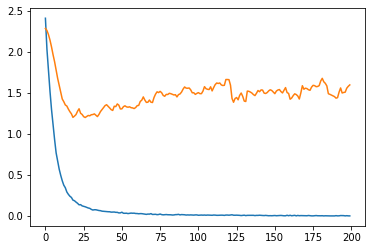

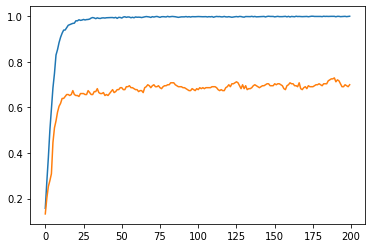

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Input,concatenate
import matplotlib.pyplot as plt

inputs_bow = keras.Input(shape=x_train_01[0].shape)
inputs_embedding = keras.Input(shape=x_train[0].shape)
  
x1= Dense(50, activation="relu")(inputs_bow)
x1= Dropout(0.2)(x1)
x1= Dense(50, activation="relu")(x1)
x1= BatchNormalization()(x1)
x1= Dropout(0.5)(x1)
x1= Dense(50, activation="relu")(x1)

x2= Embedding(VOCAB_SIZE, 40)(inputs_embedding)
x2= SpatialDropout1D(0.2)(x2)
x2= Flatten()(x2)
x2= Dense(150, activation="relu")(x2)
#x2= BatchNormalization()(x2)
x2= Dropout(0.2)(x2)
x2= Dense(50, activation="relu")(x2)
x2= BatchNormalization()(x2)
x2= Dropout(0.5)(x2)
x2= Dense(20, activation="relu")(x2)

x10 = concatenate([x1,x2])
x10= BatchNormalization()(x10)
#x10 = Dense(20, activation='tanh')(x10)
x10 = Dropout(0.5)(x10)
x10 = Dense(20, activation='tanh')(x10)
x10 = Dropout(0.2)(x10)
x10 = Dense(y_train.shape[-1], activation='softmax')(x10)

model = keras.Model(inputs=[inputs_bow,inputs_embedding], outputs=x10)#, name="conv1d model"
adamopt=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adamopt,metrics=['accuracy'])#categorical_crossentropymean_absolute_error categorical_crossentropy  mean_squared_error binary_crossentropy
model.summary()

history = model.fit(x=[x_train_01,x_train], y=y_train,validation_data=([x_test_01,x_test], y_test),epochs=200, batch_size=128)
plt.plot(history.history['loss'], label='loss train')
plt.plot(history.history['val_loss'], label='loss test')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
#Результаты
#BOW - 76
#Embedding - 67
#Conv с Embedding- 53
#BOW + Embedding - 69